In [1]:
from data_preprocessing import *
from clustering import *
from strategy import *

In [2]:
## Data file for the demo
demo_filename = "data/"
## Actual data file
actual_filename = "data/period_data.tar"

First, we explore the provided data; how many minutes of data are we missing for the period ? We chose to remove stocks that had more than 25% of data missing for the period. 

In [ ]:
period_data = preprocessing(actual_filename)

In [2]:
period_data = load_cleaned_data("data/cleaned_data.tar")

Then, based on our data, we compute the Louvain clustering algorithm to obtain our daily market states. 

Daily data shape: (210, 17640)
There are 4 clusters
The length of each clusters are Cluster
0    23
1    94
2    17
3    76
dtype: int64


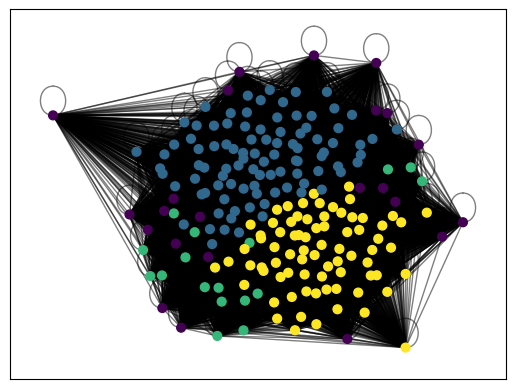

In [4]:
clusters = create_clusters(period_data)

In [12]:
## Compute the 90 percent for training and the rest for testing
period_data['date'] = period_data['xltime'].dt.date

start_date = period_data['date'].iloc[0]  # First date
end_date = period_data['date'].iloc[-1]   # Last date

period_data = period_data.drop(columns=['date'])

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

stop_date = (start_date + (end_date - start_date) * 0.20).normalize()

# Filter the DataFrame to keep rows before the stop date
train_data = period_data[period_data["xltime"] < stop_date]
test_data = period_data[period_data["xltime"] >= stop_date]

Daily data shape: (189, 17640)
There are 5 clusters
The length of each clusters are Cluster
0     4
1    84
2    37
3    61
4     3
dtype: int64


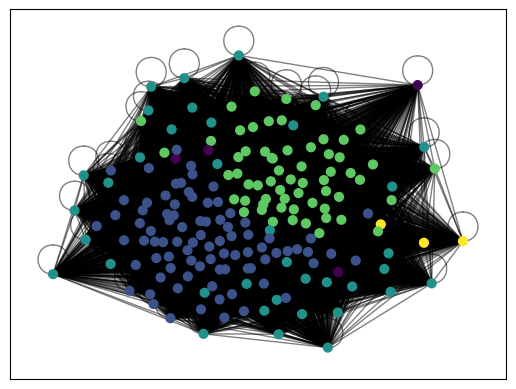

In [13]:
clusters_train, historical_log = create_clusters(train_data)

In [39]:
unique_dates = test_data["xltime"].dt.date.unique()

# Iterate through each unique date
for date in unique_dates:
    # Filter the DataFrame for the current date
    date_df = test_data[test_data["xltime"].dt.date == date]
    if(pd.to_datetime(date).date() == pd.to_datetime("2012-12-24").date()):
        continue
    new_log_returns = compute_log_returns(date_df)
    cluster = classify_new_day(new_log_returns, historical_log, clusters_train)
    new_row_data = {'Day': [date], 'Cluster': [cluster]}
    # Create a new DataFrame from the row data
    new_row = pd.DataFrame(new_row_data)
    # Add the new rows to the existing DataFrame
    clusters = pd.concat([clusters_train, new_row], ignore_index=True)


The new day is assigned to cluster 1 with similarity -3.722775737051465e-05
The new day is assigned to cluster 0 with similarity 0.03689250723432191
The new day is assigned to cluster 3 with similarity 0.0016071758369921797
The new day is assigned to cluster 3 with similarity 0.002486370240645586
The new day is assigned to cluster 3 with similarity 0.0039043988818948197
The new day is assigned to cluster 1 with similarity 6.79291608123328e-05
The new day is assigned to cluster 4 with similarity 0.012672585919906219
The new day is assigned to cluster 2 with similarity 0.00032522731528328736
The new day is assigned to cluster 0 with similarity 0.007186066068097687
The new day is assigned to cluster 4 with similarity 0.014482426894605811
The new day is assigned to cluster 4 with similarity 0.00700589794645926
The new day is assigned to cluster 0 with similarity 0.003128682212540329
The new day is assigned to cluster 4 with similarity 0.004071681455825908
The new day is assigned to cluster

Daily data shape: (168, 17640)
There are 5 clusters
The length of each clusters are Cluster
0    12
1     4
2    82
3    10
4    60
dtype: int64


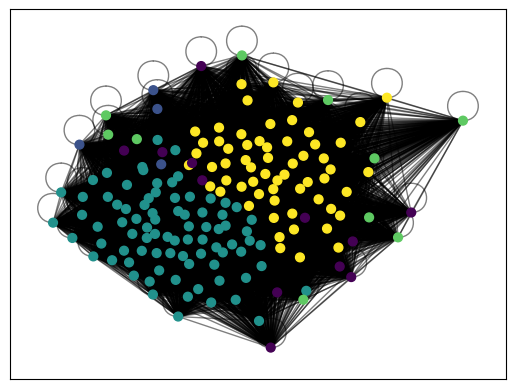

2012-10-31
The new day is assigned to cluster 1 with similarity 0.008893607592078363
2012-11-01
The new day is assigned to cluster 4 with similarity 0.003737221135871343
2012-11-02
The new day is assigned to cluster 4 with similarity 0.00229742652828364
2012-11-05
The new day is assigned to cluster 0 with similarity 0.007875646026352523
2012-11-06
The new day is assigned to cluster 1 with similarity 0.010419672005837113
2012-11-07
The new day is assigned to cluster 0 with similarity 0.006602768297895668
2012-11-08
The new day is assigned to cluster 1 with similarity 0.009152209379852746
2012-11-09
The new day is assigned to cluster 0 with similarity 0.0047444531816894925
2012-11-12
The new day is assigned to cluster 1 with similarity 0.004600547540913237
2012-11-13
The new day is assigned to cluster 3 with similarity 0.0060863582948031385
2012-11-14
The new day is assigned to cluster 3 with similarity 0.006293392579556375
2012-11-15
The new day is assigned to cluster 3 with similarity 

(            Day  Cluster
 0    2012-03-01        3
 1    2012-03-02        2
 2    2012-03-05        2
 3    2012-03-06        2
 4    2012-03-07        2
 ..          ...      ...
 203  2012-12-21        2
 204  2012-12-26        1
 205  2012-12-27        3
 206  2012-12-28        1
 207  2012-12-31        1
 
 [208 rows x 2 columns],
 305)

In [3]:
classify_test_data(period_data)